## Análisis de Datos de Temperatura

- Fecha: 2024-08-13
- Autor: Sebastian Morales
- Objetivo: realizar la isnpección sobre los datos recolectados a través del API de openweather y usando la configuración de Linux para el registro de los mismos

In [1]:
import os
import pandas as pd
os.listdir(os.getcwd())

['get-weather.sh',
 'CityTemperatureAnalysis.ipynb',
 'weather-site',
 'debug.log',
 '.ipynb_checkpoints',
 'main.py',
 'output.log',
 'clima_bogota_2024-08-13.csv']

In [2]:
os.getcwd() # pwd

'/home/sebastianmorales/proyecto'

### Lectura de Datos
Lectura del archivo csv con *with open* debido a que openweather coloca valores sobre la lluvia y la nieve cuando éstos están disponibles por lo que en este caso he obtenido 30 campos de lectura obviando los referidos. Esto puede solventarse incluyendo los campos con valor NaN por defecto en el programa de Python para captura de información

In [13]:
import csv
csv_file = 'clima_bogota_2024-08-13.csv'
filtered_rows = []
with open(csv_file, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if len(row) == 7:  # Asegúrate de que el número de columnas coincida con el encabezado
            filtered_rows.append(row)
print("Número de filas filtradas:", len(filtered_rows))

Número de filas filtradas: 28


In [10]:
header = filtered_rows[0]
data = filtered_rows[1:]
print("Número de columnas en el encabezado:", len(header))
print("Número de filas en los datos:", len(data))

Número de columnas en el encabezado: 7
Número de filas en los datos: 27


In [11]:
df = pd.DataFrame(data, columns=header)
print("Forma del DataFrame:", df.shape)

Forma del DataFrame: (27, 7)


In [14]:
df.sample(5)

,Fecha,Ciudad,Temperatura (K),Humedad (%),Descripción,Lluvia (mm),Nieve (mm)
6,30:02.4,Bogota,288.88,59,few clouds,0,0
1,30:01.8,Bogota,290.88,52,few clouds,0,0
4,10:02.4,Bogota,290.88,52,few clouds,0,0
16,30:01.8,Bogota,287.88,67,broken clouds,0,0
9,00:02.4,Bogota,288.88,59,few clouds,0,0


### Análisis de Datos
- Se procede a realizar un plot de variables de interés según el tiempo capturado. La primera columna contiene la información del API sobre tiempo en formato **Timestamp**, misma que se puede convertir a **datetime**.
- Debido al proceso utilizado para guardar los datos `dt` tiene como tipo de dato objeto por lo que es necesario convertirlo a entero. De igual manera existen otras variables capturadas que en este caso por la lectura con `with open` se detectan como object en vez de sus tipos de datos correctos


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Fecha            27 non-null     object
 1   Ciudad           27 non-null     object
 2   Temperatura (K)  27 non-null     object
 3   Humedad (%)      27 non-null     object
 4   Descripción      27 non-null     object
 5   Lluvia (mm)      27 non-null     object
 6   Nieve (mm)       27 non-null     object
dtypes: object(7)
memory usage: 1.6+ KB


In [28]:
df.dt = df.dt.astype(int)
df.sys_sunrise = df.sys_sunrise.astype(int)
df.sys_sunset = df.sys_sunset.astype(int)
for column in df.columns:
    try:
        df[column] = pd.to_numeric(df[column])
    except ValueError:
        next

AttributeError: 'DataFrame' object has no attribute 'dt'

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Fecha            28 non-null     object
 1   Ciudad           28 non-null     object
 2   Temperatura (K)  28 non-null     object
 3   Humedad (%)      28 non-null     object
 4   Descripción      28 non-null     object
 5   Lluvia (mm)      28 non-null     object
 6   Nieve (mm)       28 non-null     object
dtypes: object(7)
memory usage: 1.7+ KB


In [20]:
from datetime import datetime
df_etl = df.copy()
df_etl.dt = df.dt.apply(lambda x: datetime.fromtimestamp(x))
df_etl.sys_sunrise = df.sys_sunrise.apply(lambda x: datetime.fromtimestamp(x))
df_etl.sys_sunset = df.sys_sunset.apply(lambda x: datetime.fromtimestamp(x))
df_etl.sample(5)

AttributeError: 'DataFrame' object has no attribute 'dt'

Generalmente es de interés realizar un breve análisis estadístico de las variables del dataset

In [21]:
df_etl.describe().transpose()

,count,unique,top,freq
Fecha,27,25,20:02.1,2
Ciudad,27,1,Bogota,27
Temperatura (K),27,4,287.88,12
Humedad (%),27,4,67,12
Descripción,27,3,broken clouds,13
Lluvia (mm),27,1,0,27
Nieve (mm),27,1,0,27


In [22]:
df_etl.to_csv('clima-quito-hoy-etl.csv', index=False)

### Presentación de Resultados

Se procede a realizar gráficas de interés para estudiar el comportamiento climatológico

/tmp/ipykernel_56500/1358705737.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_etl = pd.read_csv(nombre_archivo, parse_dates=['Fecha'])


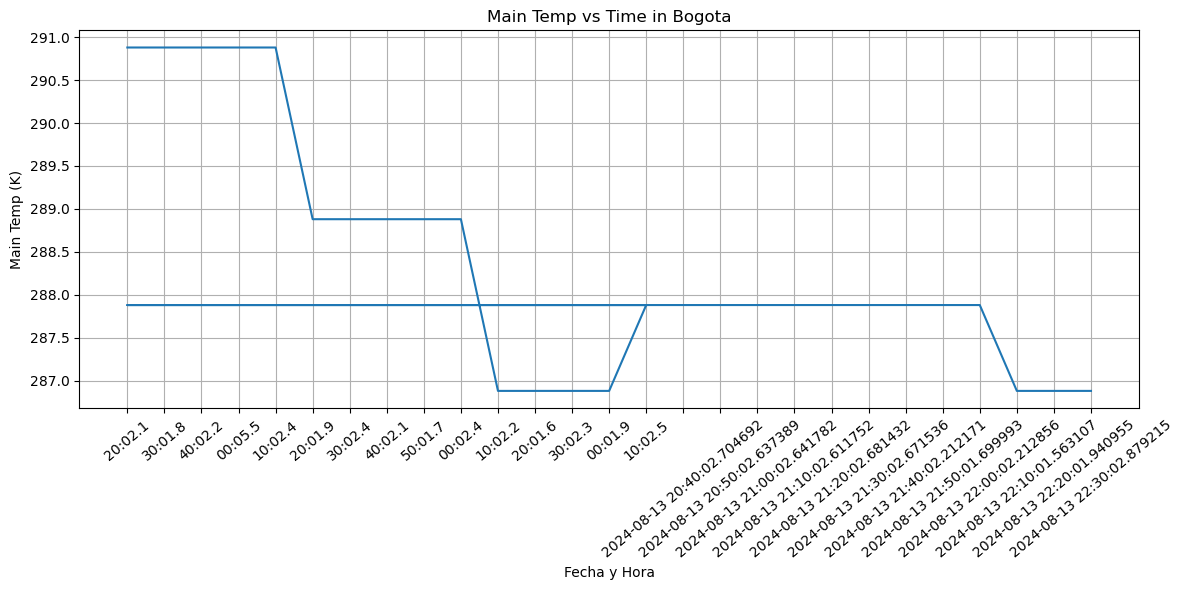

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Leer el archivo CSV
fecha_actual = datetime.date.today()
nombre_archivo = f"/home/sebastianmorales/proyecto/clima_bogota_{fecha_actual}.csv"

df_etl = pd.read_csv(nombre_archivo, parse_dates=['Fecha'])
df_etl.rename(columns={'Fecha': 'dt', 'Temperatura (K)': 'main_temp'}, inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df_etl['dt'], df_etl['main_temp'])
plt.grid()
plt.title(f'Main Temp vs Time in {next(iter(set(df_etl.Ciudad)))}')
plt.xlabel('Fecha y Hora')
plt.ylabel('Main Temp (K)')
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()

In [40]:
import plotly.express as px
import pandas as pd

# Leer el archivo CSV
fecha_actual = datetime.date.today()
nombre_archivo = f"/home/sebastianmorales/proyecto/clima_bogota_{fecha_actual}.csv"

df_etl = pd.read_csv(nombre_archivo, parse_dates=['Fecha'])
df_etl.rename(columns={'Fecha': 'dt', 'Temperatura (K)': 'main_temp', 'Humedad (%)': 'main_humidity'}, inplace=True)

fig = px.line(df_etl, x='dt', y=['main_temp', 'main_humidity'], title=f"Main Temp & Humidity vs Time in {next(iter(set(df_etl.Ciudad)))}")
fig.show()


ModuleNotFoundError: No module named 'plotly'

/tmp/ipykernel_56500/3576148493.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_etl = pd.read_csv(nombre_archivo, parse_dates=['Fecha'])


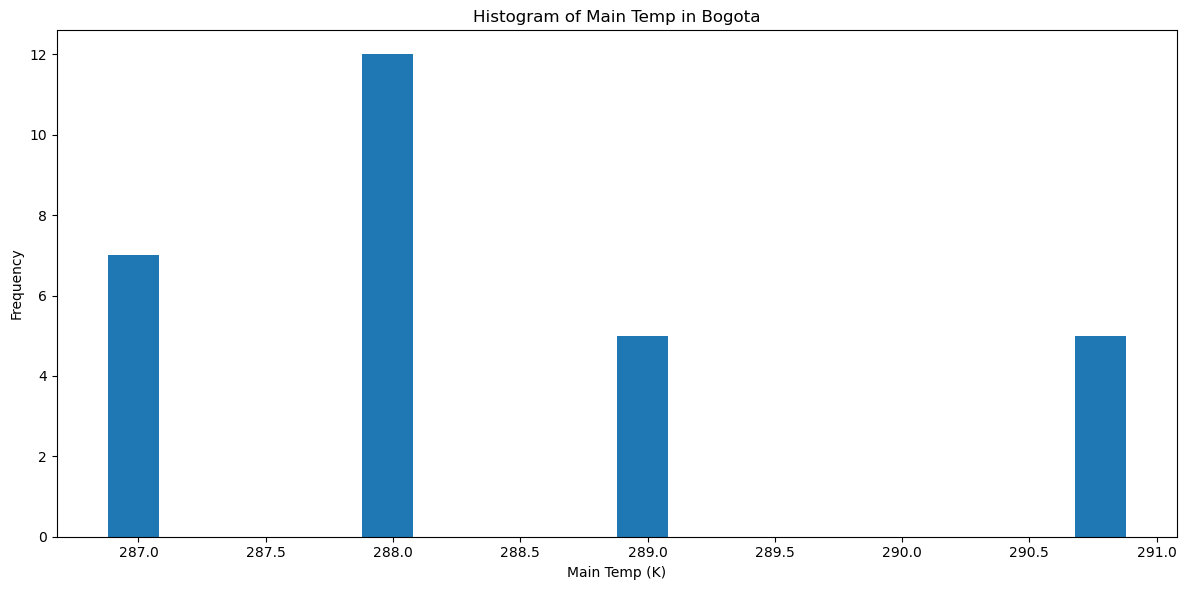

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Leer el archivo CSV
fecha_actual = datetime.date.today()
nombre_archivo = f"/home/sebastianmorales/proyecto/clima_bogota_{fecha_actual}.csv"

df_etl = pd.read_csv(nombre_archivo, parse_dates=['Fecha'])
df_etl.rename(columns={'Fecha': 'dt', 'Temperatura (K)': 'main_temp'}, inplace=True)

plt.figure(figsize=(12, 6))
df_etl['main_temp'].hist(bins=20)
plt.title(f'Histogram of Main Temp in {next(iter(set(df_etl.Ciudad)))}')
plt.xlabel('Main Temp (K)')
plt.ylabel('Frequency')
plt.grid()
plt.tight_layout()
plt.show()



In [37]:
import plotly.express as px
import pandas as pd

# Leer el archivo CSV
fecha_actual = datetime.date.today()
nombre_archivo = f"/home/sebastianmorales/proyecto/clima_bogota_{fecha_actual}.csv"

df_etl = pd.read_csv(nombre_archivo, parse_dates=['Fecha'])
df_etl.rename(columns={'Fecha': 'dt', 'Temperatura (K)': 'main_temp'}, inplace=True)

fig = px.violin(df_etl, y='main_temp', title=f"Violin Plot Main Temp in {next(iter(set(df_etl.Ciudad)))}")
fig.show()


ModuleNotFoundError: No module named 'plotly'

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Leer el archivo CSV
fecha_actual = datetime.date.today()
nombre_archivo = f"/home/sebastianmorales/proyecto/clima_bogota_{fecha_actual}.csv"

df_etl = pd.read_csv(nombre_archivo, parse_dates=['Fecha'])
df_etl.rename(columns={'Fecha': 'dt', 'Temperatura (K)': 'main_temp'}, inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df_etl['dt'], df_etl['main_temp'])
plt.grid()
plt.title(f'Main Temp vs Time in {next(iter(set(df_etl.Ciudad)))}')
plt.xlabel('Fecha y Hora')
plt.ylabel('Main Temp (K)')
plt.xticks(rotation=40)
plt.tight_layout()
fname = '/home/sebastianmorales/proyecto/weather-site/content/images/temperature.pdf'
plt.savefig(fname)
plt.close()


/tmp/ipykernel_56500/4118733715.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_etl = pd.read_csv(nombre_archivo, parse_dates=['Fecha'])


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 5))
tips = sns.load_dataset("tips")
sns.boxplot(x="day", y="tip", data=tips)
plt.title('Boxplot of Tips by Day')
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'seaborn'